In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Dropout, Conv2D, Flatten, MaxPooling2D, Activation, Input

In [2]:
#Create Discriminator

def create_discriminator(img_shape=(28,28,1),summary=True):
  model=Sequential()
  model.add(Input(shape=img_shape))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(0.3))
  model.add(Dense(256))
  model.add(LeakyReLU(0.3))
  model.add(Dense(1,activation='sigmoid'))
  if summary:
        model.summary()
  return model


In [3]:
#Create Generator

def create_generator(z_dim=100, output_shape=(28, 28, 1), summary=True):
    model = Sequential()
    model.add(Input(shape=(z_dim,)))
    model.add(Dense(256))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum=0.8))

    # Flattened output size to match output shape
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))

    if summary:
        model.summary()

    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

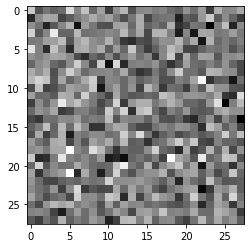

In [4]:
#Intial Images generated by generator
generator=create_generator()

noise=tf.random.normal(shape=(1,100))
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

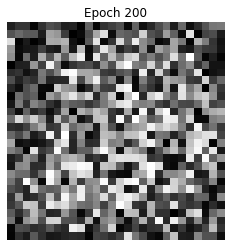

1/1 [==============================] - 0s 24ms/step
400 [D loss: 0.5348846614360809, acc.: 75.00%] [G loss: 1.3846485614776611]
1/1 [==============================] - 0s 20ms/step


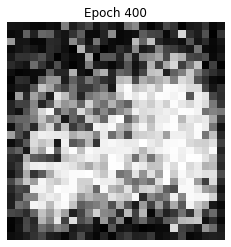

1/1 [==============================] - 0s 22ms/step
600 [D loss: 0.5374598205089569, acc.: 81.25%] [G loss: 1.0771598815917969]
1/1 [==============================] - 0s 11ms/step


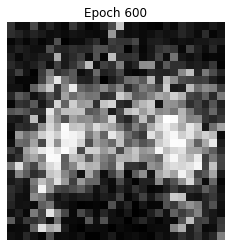

1/1 [==============================] - 0s 29ms/step
800 [D loss: 0.6162329316139221, acc.: 73.44%] [G loss: 1.0356252193450928]
1/1 [==============================] - 0s 31ms/step


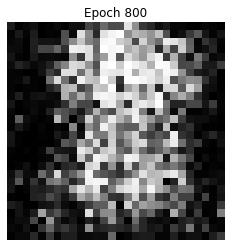

1/1 [==============================] - 0s 30ms/step
1000 [D loss: 0.5977080464363098, acc.: 78.12%] [G loss: 0.9563173055648804]
1/1 [==============================] - 0s 16ms/step


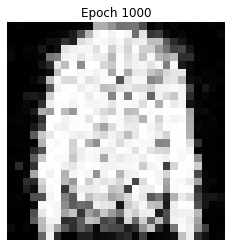

In [6]:

def training(generator=None, discriminator=None, gan_model=None, epochs=1000, batch_size=128, z_dim=100, sample_interval=200):
  (X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

  X_train=X_train/127.5-1.0

  real_y=np.ones((batch_size))  #labels
  fake_y=np.zeros((batch_size))

  for i in range(epochs):
    id=np.random.randint(0,X_train.shape[0],batch_size)  #Real images
    real_images=X_train[id]


    disc_loss_real=discriminator.train_on_batch(real_images,real_y)

    noise=np.random.normal(0,1,(batch_size,z_dim)) #Fake images
    fake_images=generator.predict(noise)
    disc_loss_fake=discriminator.train_on_batch(fake_images,fake_y)

    discriminators_loss=0.5*np.add(disc_loss_real,disc_loss_fake)
    noise=np.random.normal(0,1,(batch_size,z_dim))
    gen_loss=gan_model.train_on_batch(noise,real_y)
    if (i + 1) % sample_interval == 0:
            print(f"{i + 1} [D loss: {discriminators_loss[0]}, acc.: {100 * discriminators_loss[1]:.2f}%] [G loss: {gen_loss}]")
            sample_images(generator, i + 1)


def sample_images(generator, epoch, z_dim=100):
    noise = np.random.normal(0, 1, (1, z_dim))
    gen_image = generator.predict(noise)

    gen_image = 0.5 * gen_image + 0.5  # Rescale to [0, 1] for display

    plt.imshow(gen_image[0, :, :, 0], cmap='gray')
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.show()
    
    



discriminator=create_discriminator()
generator=create_generator()

discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])
z_dim=100
z=Input(shape=(z_dim,))
img=generator(z)

discriminator.trainable=False
validity=discriminator(img)

gan_model=Model(z,validity)
gan_model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))
gan_model

training(generator, discriminator, gan_model, epochs=10000, batch_size=32, sample_interval=200)


